In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers import Dropout
from keras.engine.sequential import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
data_path = 'data/201709-202201.csv'
data = pd.read_csv(data_path)
data = data.drop(['Unnamed: 0', 'timestamp'], axis=1)

data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count,MACD,SMA,OBV,RSI,MFI,vader_pos,vader_neg,vader_neu,vader_compound,pos_count,neg_count,neu_count
0,4734.26,4935.00,4671.09,4921.70,15367.529697,26908,291.248511,4637.594,15367.529697,84.634034,66.963403,0.099990,0.037505,0.862486,0.176250,53,16,36
1,4921.71,4979.90,4488.50,4599.90,16977.793622,29688,284.618369,4681.576,-1610.263925,63.137827,76.855935,0.082010,0.049178,0.868832,0.071590,31,23,47
2,4599.90,4700.00,4385.00,4606.26,11224.914556,22080,285.125719,4687.064,9614.650631,61.605230,81.298006,0.105273,0.043869,0.850869,0.147783,40,19,40
3,4603.68,4613.97,4058.50,4277.00,25069.125230,43072,258.859964,4627.824,-15454.474599,49.206076,88.025975,0.063162,0.061717,0.875121,0.039875,30,23,46
4,4282.53,4474.88,4001.93,4396.52,20884.219694,30792,268.394323,4560.276,5429.745095,51.433513,91.971831,0.090814,0.037608,0.871569,0.126061,40,18,44


In [3]:
'''Price Data:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator:'''
data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'pos_count', 'neg_count', 'neu_count'], axis=1)


data_labels = data['price_close']

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))


train_size1 = int(0.8 * len(label))
train_size2 = int(0.9 * len(label))

In [4]:
def split_data(f, l, delay):
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay-1])
        
    return np.array(feature), np.array(label).squeeze()

GRU_window_size = 5
LSTM_window_size = 5

X_train_GRU, y_train_GRU = split_data(feature[:train_size1], label[:train_size1], GRU_window_size)
X_train_LSTM, y_train_LSTM = split_data(feature[:train_size1], label[:train_size1], LSTM_window_size)
X_train2_GRU, y_train2_GRU = split_data(feature[train_size1:train_size2], label[train_size1:train_size2], GRU_window_size)
X_train2_LSTM, y_train2_LSTM = split_data(feature[train_size1:train_size2], label[train_size1:train_size2], LSTM_window_size)
X_test_GRU, y_test_GRU = split_data(feature[train_size2:], label[train_size2:], GRU_window_size)
X_test_LSTM, y_test_LSTM = split_data(feature[train_size2:], label[train_size2:], LSTM_window_size)

# RNN

In [5]:
nGRU = 7
nRNN = 3

In [6]:
GRUs = [
    keras.Sequential([
        layers.GRU(1024),
        layers.Dense(512),
        layers.Dense(1)
    ]) for i in range(nGRU)
]


RNNs = [
    keras.Sequential([
        layers.SimpleRNN(1024),
        layers.Dense(512),
        layers.Dense(1)
    ]) for i in range(nRNN)
]

2022-10-05 10:33:20.493536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 10:33:20.525960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 10:33:20.526236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 10:33:20.527298: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [26]:
for i, model in enumerate(GRUs):
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00005),
                  metrics=[keras.metrics.RootMeanSquaredError()]
                  )
    history = model.fit(X_train_GRU, y_train_GRU,
                        epochs=30,
                        batch_size=4,
                        validation_data=(X_train2_GRU, y_train2_GRU),
                        callbacks=[keras.callbacks.ModelCheckpoint('gru-1day-'+str(i)+'.h5', verbose=1, monitor='val_root_mean_squared_error',save_best_only=True, mode='auto')],
                        shuffle=True
                        )

Epoch 1/30


/home/charles/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-10-05 10:10:42.676815: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8400


249/249 [==============================] - 3s 4ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 8.8895e-05 - val_root_mean_squared_error: 0.0094

Epoch 00001: val_root_mean_squared_error improved from inf to 0.00943, saving model to gru-1day-0.h5
Epoch 2/30
249/249 [==============================] - 1s 4ms/step - loss: 1.0529e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.1107e-04 - val_root_mean_squared_error: 0.0105

Epoch 00002: val_root_mean_squared_error did not improve from 0.00943
Epoch 3/30
249/249 [==============================] - 2s 8ms/step - loss: 1.1270e-04 - root_mean_squared_error: 0.0106 - val_loss: 5.7213e-05 - val_root_mean_squared_error: 0.0076

Epoch 00003: val_root_mean_squared_error improved from 0.00943 to 0.00756, saving model to gru-1day-0.h5
Epoch 4/30
249/249 [==============================] - 1s 4ms/step - loss: 1.0440e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.5324e-04 - val_root_mean_squared_error: 0.0124

Epoch 00004: va

In [27]:
for i, model in enumerate(RNNs):
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00005),
                  metrics=[keras.metrics.RootMeanSquaredError()]
                  )
    history = model.fit(X_train_LSTM, y_train_LSTM,
                        epochs=30,
                        batch_size=4,
                        validation_data=(X_train2_LSTM, y_train2_LSTM),
                        callbacks=[keras.callbacks.ModelCheckpoint('rnn-1day-'+str(i)+'.h5', verbose=1, monitor='val_root_mean_squared_error',save_best_only=True, mode='auto')],
                        shuffle=True
                        )

Epoch 1/30


/home/charles/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


249/249 [==============================] - 1s 3ms/step - loss: 0.1112 - root_mean_squared_error: 0.3334 - val_loss: 5.1869e-05 - val_root_mean_squared_error: 0.0072

Epoch 00001: val_root_mean_squared_error improved from inf to 0.00720, saving model to rnn-1day-0.h5
Epoch 2/30
249/249 [==============================] - 1s 3ms/step - loss: 1.5260e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.7711e-04 - val_root_mean_squared_error: 0.0133

Epoch 00002: val_root_mean_squared_error did not improve from 0.00720
Epoch 3/30
249/249 [==============================] - 1s 3ms/step - loss: 1.1550e-04 - root_mean_squared_error: 0.0107 - val_loss: 2.0209e-05 - val_root_mean_squared_error: 0.0045

Epoch 00003: val_root_mean_squared_error improved from 0.00720 to 0.00450, saving model to rnn-1day-0.h5
Epoch 4/30
249/249 [==============================] - 1s 3ms/step - loss: 1.2103e-04 - root_mean_squared_error: 0.0110 - val_loss: 2.9250e-05 - val_root_mean_squared_error: 0.0054

Epoch 00004: va

In [7]:
GRU = [tf.keras.models.load_model('gru-1day-'+str(i)+'.h5') for i in range(nGRU)]
RNN = [tf.keras.models.load_model('rnn-1day-'+str(i)+'.h5') for i in range(nRNN)]
pred_GRU = [model.predict(X_test_GRU) for model in GRU]
pred_RNN = [model.predict(X_test_GRU) for model in RNN]

2022-10-05 10:33:32.717170: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-05 10:33:33.869675: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8400


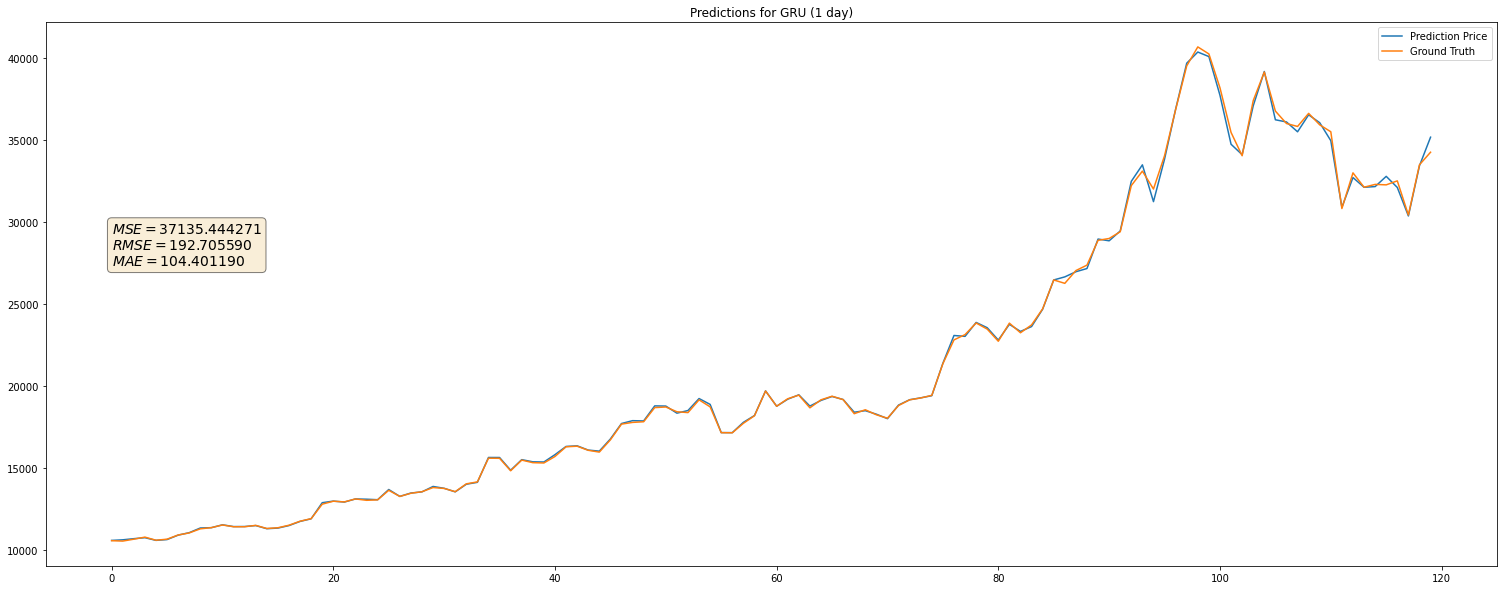

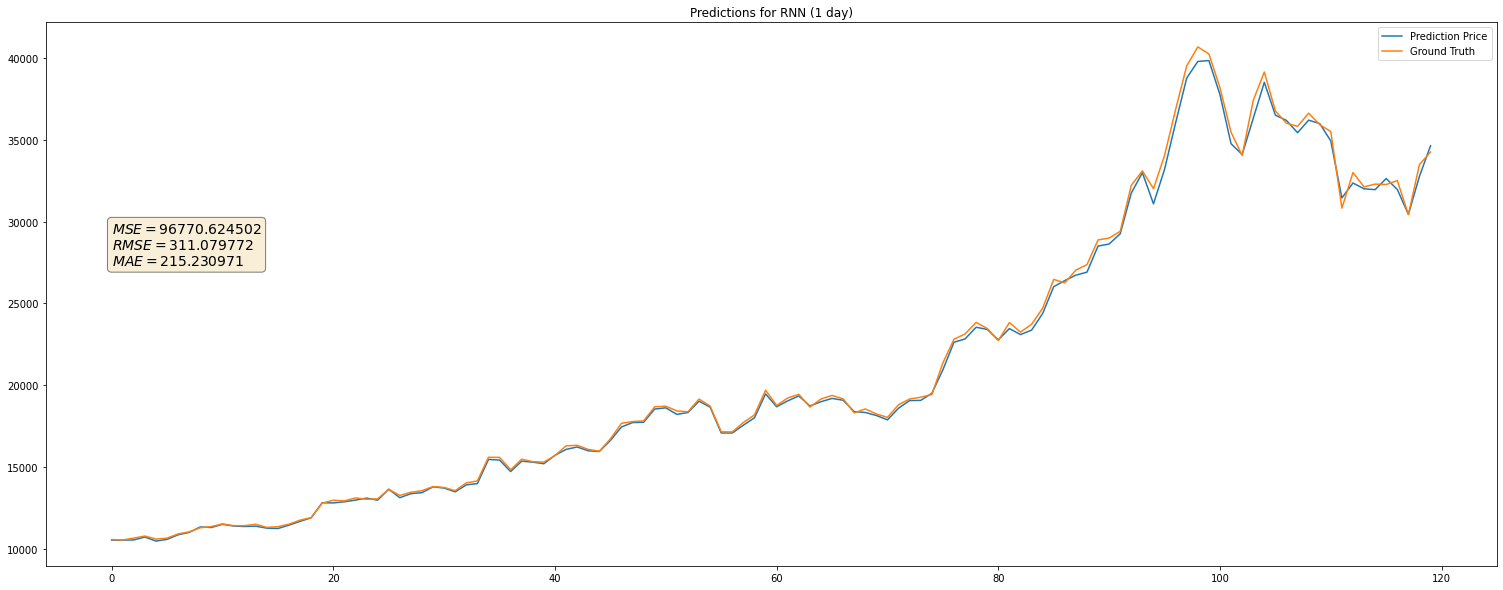

In [8]:
prediction = np.mean(np.array(pred_GRU), axis=0)
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test_GRU.reshape(-1,1))

mse = mean_squared_error(pred_prices, true_prices)
rmse = mean_squared_error(pred_prices, true_prices, squared=False)
mae = mean_absolute_error(pred_prices, true_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for GRU (1 day)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 30000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()


prediction = np.mean(np.array(pred_RNN), axis=0)
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test_LSTM.reshape(-1,1))

mse = mean_squared_error(pred_prices, true_prices)
rmse = mean_squared_error(pred_prices, true_prices, squared=False)
mae = mean_absolute_error(pred_prices, true_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for RNN (1 day)')
 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 30000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()

In [9]:
pred_GRU = [model.predict(X_train2_GRU) for model in GRU]
pred_RNN = [model.predict(X_train2_LSTM) for model in RNN]
pred_RNN = np.array(pred_RNN)
pred_GRU = np.array(pred_GRU)

tmp = np.concatenate((pred_GRU, pred_RNN), axis=0).squeeze().transpose()
# tmp = pred_GRU.squeeze().transpose()

# print(tmp[:10])
# print("-----")
# print(y_train2_GRU[:10])

# MLP

In [10]:
batch_size = 8
model = Sequential([
                    Dense(50),
                    Dense(100),

                    # Activation('relu'),
                    # Dropout(0.2),
                    Dense(25),
                    Dense(1)
                    ])

model.compile(optimizer= Adam(learning_rate=5e-4), loss='mse', metrics=['accuracy'])

model.fit(tmp, y_train2_GRU, batch_size = batch_size, epochs=50, verbose = 1)

Epoch 1/50
15/15 [==============================] - 0s 1ms/step - loss: 0.0152 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 1ms/step - loss: 4.5236e-04 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 990us/step - loss: 1.5541e-04 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 1ms/step - loss: 6.9708e-05 - accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 0s 1ms/step - loss: 4.5484e-05 - accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 1ms/step - loss: 4.5229e-05 - accuracy: 0.0000e+00
Epoch 8/50
15/15 [==============================] - 0s 1ms/step - loss: 3.6103e-05 - accuracy: 0.0000e+00
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 3.3816e-05 - accuracy: 0.0000e+00
Epoch 10/50
15/15 [==============================] -

In [11]:
pred_GRU = [model.predict(X_test_GRU) for model in GRU]
pred_RNN = [model.predict(X_test_GRU) for model in RNN]

pred_RNN = np.array(pred_RNN)
pred_GRU = np.array(pred_GRU)

tmp2 = np.concatenate((pred_GRU, pred_RNN), axis=0).squeeze().transpose()
# tmp2 = pred_GRU.squeeze().transpose()

# tmp2 = np.concatenate((pred_GRU, pred_LSTM), axis=1)
print(tmp2.shape)
# tmp2 = np.squeeze(tmp2, axis=2).transpose()
prediction = model.predict(tmp2)

(120, 10)


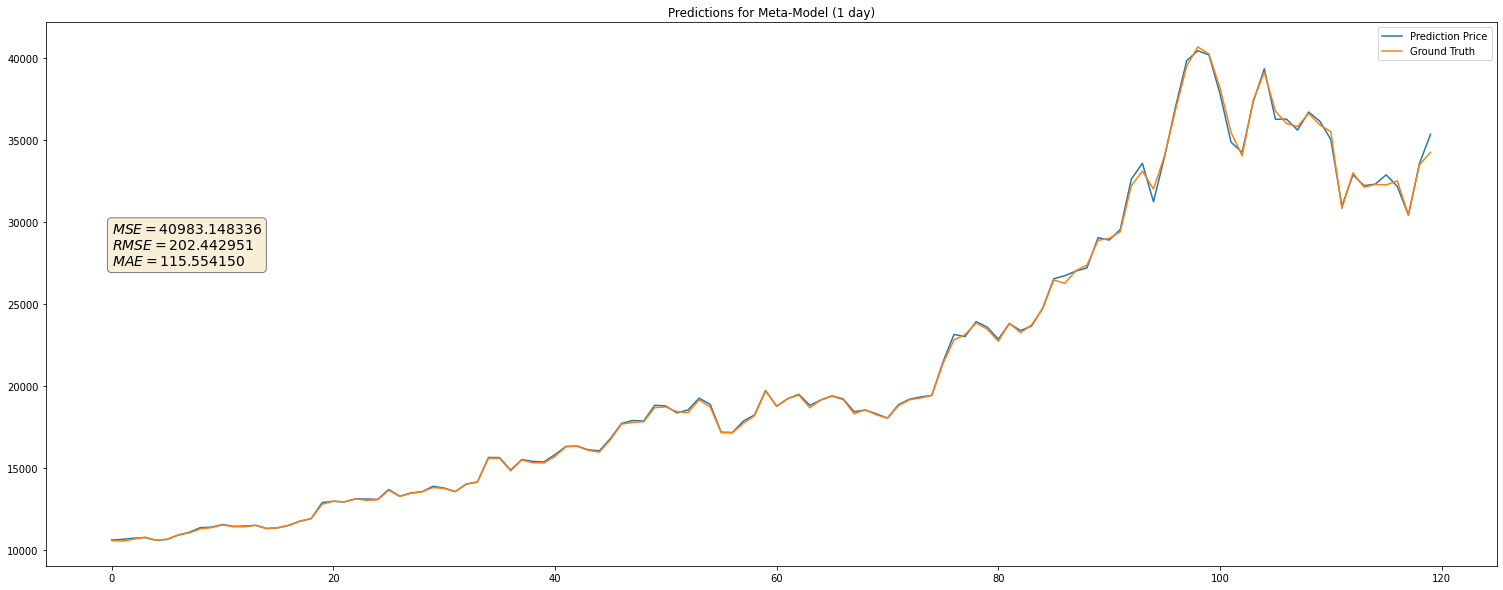

In [12]:
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test_GRU.reshape(-1,1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for Meta-Model (1 day)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 30000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()